In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from typing import Tuple
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from PIL import Image
from tqdm import tqdm

In [2]:
def show_example(img, label):
    print(label)
    plt.imshow(img.permute(1, 2, 0))

In [3]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [4]:
labels_csv_file = pd.read_csv('F:\Projects\Disertatie\AADB\Dataset.csv', delimiter=",")
labels_csv_file.head()

,ImageFile,BalacingElements,ColorHarmony,Content,DoF,Light,MotionBlur,Object,Repetition,RuleOfThirds,score,Symmetry,VividColor
0,farm1_333_19438364933_087c8abc60_b.jpg,-0.2,0.2,-0.2,-0.4,0.0,0.0,-0.4,0.0,-0.2,0.30,0.0,0.0
1,farm1_452_19898743300_201156d984_b.jpg,0.2,0.4,0.6,-0.2,0.2,0.0,0.6,0.0,0.8,0.70,0.0,0.4
2,farm1_281_20247100976_c8141d3653_b.jpg,-0.2,0.0,0.4,-0.2,-0.4,0.0,-0.6,0.0,-0.4,0.40,0.0,0.6
3,farm1_448_19709457333_be4c6bb5eb_b.jpg,0.0,0.6,-0.6,-0.2,0.0,0.0,0.2,0.2,0.0,0.60,0.0,0.4
4,farm1_393_20179744375_c119001350_b.jpg,-0.2,0.6,0.4,0.0,-0.4,0.0,0.2,0.0,0.0,0.45,0.0,0.2


In [5]:
image_dir = 'F:\Projects\Disertatie\AADB\ImageAesthetics_ECCV2016\datasetImages_warp256'
label_csv_path = 'F:\Projects\Disertatie\AADB\\'

In [8]:
class AADB(Dataset):

    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score"
    ]

    def __init__(self, image_dir, label_csv_path, test=False):
        self.label_csv_path = label_csv_path
        self.image_dir = image_dir
        self.test=test
        self.transform = T.Compose([T.Resize(size=(64, 64)), T.ToTensor()])
        self.files, self.labels = self.load_data(self.image_dir, self.label_csv_path, self.test)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(self.files[index]).convert("RGB")
#         print("Image Name: {}".format(self.files[index].split("/")[-1]))
        image = self.transform(image)
        label = torch.from_numpy(self.labels[index])
        return image, label

    def load_data(self, image_dir, csv_path, test=False):
        csv_file = csv_path + 'Dataset.csv' if not test else csv_path + 'Dataset_test.csv'
        label_csv = pd.read_csv(csv_file, delimiter=",")
        files = [os.path.join(image_dir, f) for f in label_csv['ImageFile']]
        label_csv_normed = self.prepare_csv_file(label_csv)     # this is for norming values
        label_csv_rounded = self.round_labels(label_csv_normed)
        labels = np.asarray([label.values for index, label in label_csv_rounded.iterrows()])
        return files, labels

    def normalize(self, array):
        array_norm = (array - np.min(array)) / (np.max(array) - np.min(array))
        return array_norm

    def prepare_csv_file(self, csv_file):
        """
        Moves the score column to the last and normalize all the values between [0, 1]
        :param csv_file:
        :return: normalized csv_file
        """
        columns = csv_file.columns.tolist()
        columns.pop(columns.index('score'))
        columns.append('score')
        csv_file = csv_file.reindex(columns=columns)

        for column in csv_file.drop(['ImageFile'], axis=1):
            normed_values = self.normalize(csv_file[column].values)
            csv_file[column] = normed_values

        return csv_file.drop(['ImageFile', 'score'], axis=1)

    def round_labels(self, csv_file):

        for index, label in csv_file.iterrows():
            for value in csv_file.columns:
                if np.logical_and(label[value] >= 0, label[value] <0.2):
                    label[value] = 0
                elif np.logical_and(label[value] >= 0.2, label[value] <0.4):
                    label[value] = 1
                elif np.logical_and(label[value] >= 0.4, label[value] <0.6):
                    label[value] = 2
                elif np.logical_and(label[value] >= 0.6, label[value] <0.8):
                    label[value] = 3
                elif np.logical_and(label[value] >= 0.8, label[value] <=1):
                    label[value] = 4

        return csv_file




In [9]:
aadb = AADB(image_dir, label_csv_path)
aadb_test = AADB(image_dir, label_csv_path, test=True)

tensor([2., 3., 2., 1., 2., 2., 1., 0., 1., 0., 2.], dtype=torch.float64)


8958

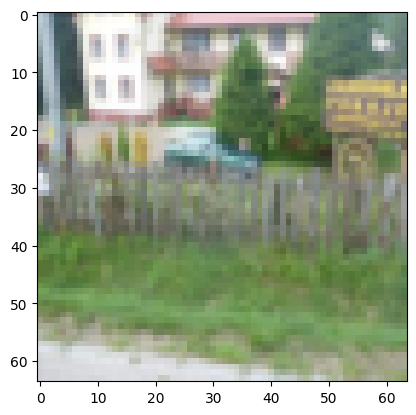

In [10]:
show_example(*aadb[0])
len(aadb)

tensor([2., 4., 4., 4., 2., 2., 4., 0., 2., 0., 2.], dtype=torch.float64)


1000

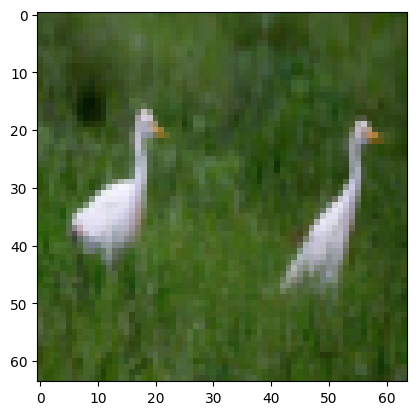

In [11]:
show_example(*aadb_test[0])
len(aadb_test)

In [20]:
val_size = 500
train_size = len(aadb) - val_size

train_ds, val_ds = random_split(aadb, [train_size, val_size])
len(train_ds), len(val_ds)

(8458, 500)

In [24]:
batch_size = 32
epochs = 50

In [25]:
train_dl = DataLoader(train_ds, batch_size*2, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)

In [27]:
for image, _ in train_dl:
    print(image.shape)
    break

torch.Size([64, 3, 64, 64])


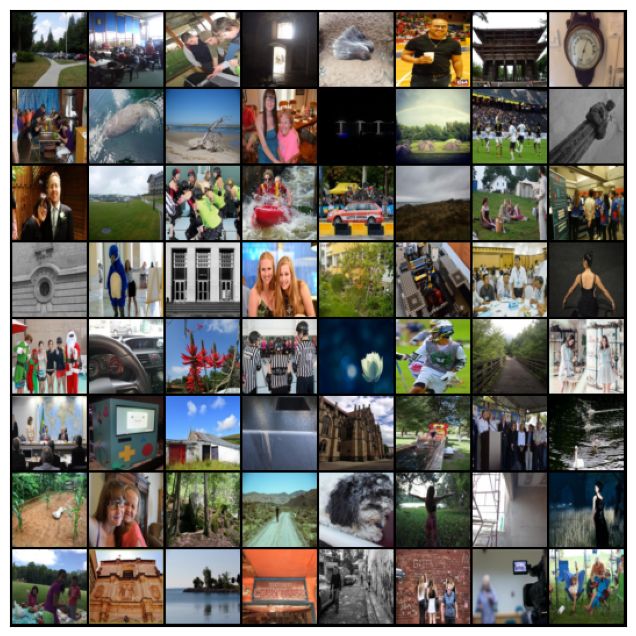

In [26]:
show_batch(train_dl)